In [19]:
pip install --ignore-installed blinker

  Using cached blinker-1.8.2-py3-none-any.whl.metadata (1.6 kB)
Using cached blinker-1.8.2-py3-none-any.whl (9.5 kB)


In [20]:
!pip install dash

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import io
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import plotly.express as px
from dash import Dash, dcc, html, Input, Output

## STEP 1 INITIAL DATA PROCESSING

- The data set is imported
- Coloumn named 'type' will now be called 'event_type'
- Dictionary for the the 6 events is defined
- 100 samples from each event have been taken
- The shape of the data is printed


In [22]:
data = pd.read_csv("/content/data_hep.csv")
datadf = data.rename(columns={'type': 'event_type'})
datadf = datadf.iloc[:, 1:]


# DICTIONARY
event_types = {
    "e+ e- -> Upsilon(4S) -> B+ B-": 0,
    "e+ e- -> Upsilon(4S) -> B0 B0-bar": 1,
    "e+ e- -> c c-bar": 2,
    "e+ e- -> u u-bar": 3,
    "e+ e- -> d d-bar": 4,
    "e+ e- -> s s-bar": 5
}


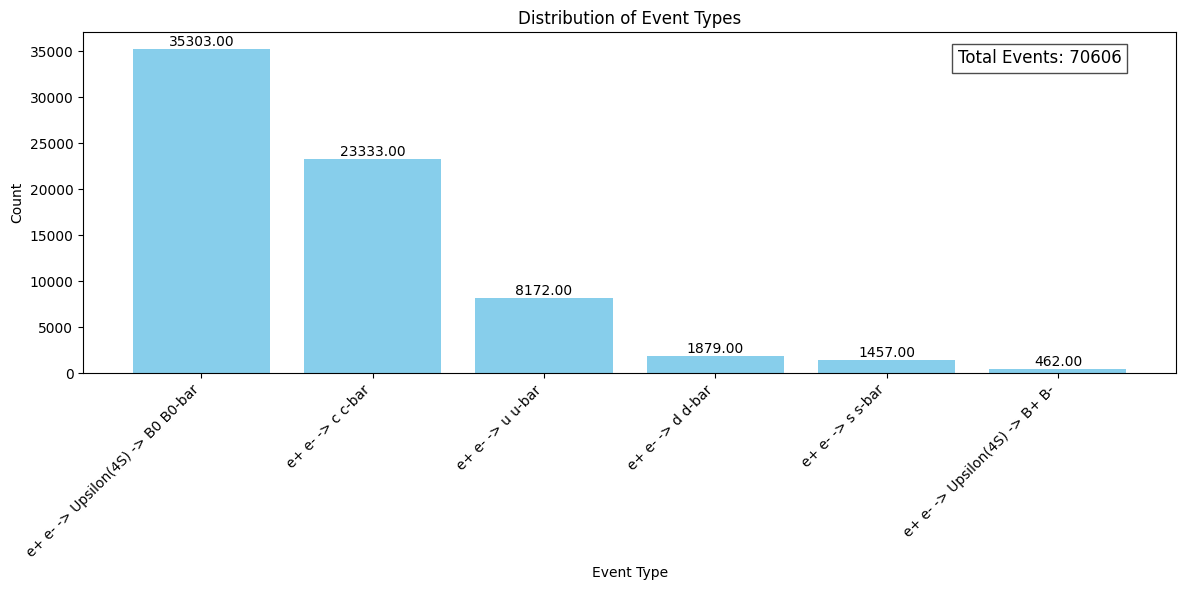

In [23]:
reverse_event_types = {v: k for k, v in event_types.items()}
event_counts = datadf['event_type'].value_counts()
total_events = event_counts.sum()
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(event_counts)), event_counts.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.text(0.95, 0.95, f'Total Events: {total_events}', transform=plt.gca().transAxes,
         fontsize=12, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.7))

plt.xticks(range(len(event_counts)),
           [reverse_event_types.get(int(i), str(i)) for i in event_counts.index],
           rotation=45, ha='right')

plt.xlabel('Event Type')
plt.ylabel('Count')
plt.title('Distribution of Event Types')
plt.tight_layout()
plt.show()


In [24]:
# 100 SAMPLING FOR EACH EVENTS
sampled_data = pd.DataFrame()

for event_type, label in event_types.items():
    class_data = datadf[datadf['event_type'] == label]
    sampled_class_data = class_data.sample(n=100, random_state=42)
    sampled_data = pd.concat([sampled_data, sampled_class_data], ignore_index=True)

print(f"Shape of sampled data: {sampled_data.shape}")

Shape of sampled data: (600, 60)


# STEP 2: DIMENTIONALITY REDUCTION

## 2.1 LDA
We have used Linear Discriminant Analysis (LDA) because of it's supervised nature. And hence it will be helpful in our task of classifing events. \\
**n_components paramter** has been selected to it's maximum value of 5 (number of classes - 1).


In [25]:
# LDA
lda = LinearDiscriminantAnalysis(n_components=5)
X_lda = lda.fit_transform(sampled_data.drop('event_type', axis=1), sampled_data['event_type'])

lda_data = pd.DataFrame(data=X_lda, columns=[f'LDA Component {i}' for i in range(1, 6)])
lda_data['Event Type'] = sampled_data['event_type']


## 2.2 LDA RESULTS

### A) 2D SCATTER MATRIX:
Plots LDA Components 1 to 5 with each other in a 2D Scatter matrix with different event types highlighed using different colours. \\
It helps us see if the classes are being seperated.

In [26]:
#SCATTER MATRIX
fig = px.scatter_matrix(
    lda_data,
    dimensions=[f'LDA Component {i}' for i in range(1, 6)],
    color='Event Type',
    title='Scatter Matrix of LDA-Transformed Data',
    labels={f'LDA Component {i}': f'LDA Component {i}' for i in range(1, 6)},
)
fig.update_traces(diagonal_visible=False)
fig.show()

### B) 3D SCATTER MATRIX:

**Note: To use this, please make sure that Dash is installed and previous snippets of code have been run.** \\

This code gives the user the option to generate a 3D Scatter Matrix to visualise 3 LDA Components at the same time. This is done using a dash application and plotly for interactive plotting. The user can also access the application using this link after running the code: http://127.0.0.1:8050/


In [27]:
# 3D SCATTER PLOT

app = Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='x-axis-dropdown',
        options=[{'label': f'LDA Component {i}', 'value': f'LDA Component {i}'} for i in range(1, 6)],
        value='LDA Component 1',  # Default value
        clearable=False
    ),
    dcc.Dropdown(
        id='y-axis-dropdown',
        options=[{'label': f'LDA Component {i}', 'value': f'LDA Component {i}'} for i in range(1, 6)],
        value='LDA Component 2',  # Default value
        clearable=False
    ),
    dcc.Dropdown(
        id='z-axis-dropdown',
        options=[{'label': f'LDA Component {i}', 'value': f'LDA Component {i}'} for i in range(1, 6)],
        value='LDA Component 3',  # Default value
        clearable=False
    ),
    dcc.Graph(id='3d-scatter-plot')
])

@app.callback(
    Output('3d-scatter-plot', 'figure'),
    Input('x-axis-dropdown', 'value'),
    Input('y-axis-dropdown', 'value'),
    Input('z-axis-dropdown', 'value')
)
def update_scatter_plot(x_axis, y_axis, z_axis):
    fig = px.scatter_3d(
        lda_data,
        x=x_axis,
        y=y_axis,
        z=z_axis,
        color='Event Type',
        title='3D Scatter Plot of LDA-Transformed Data',
        labels={
            'Event Type': 'Event Type'
        }
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

Post LDA, the transformation matrix helps us know that which feature is more important in ter so

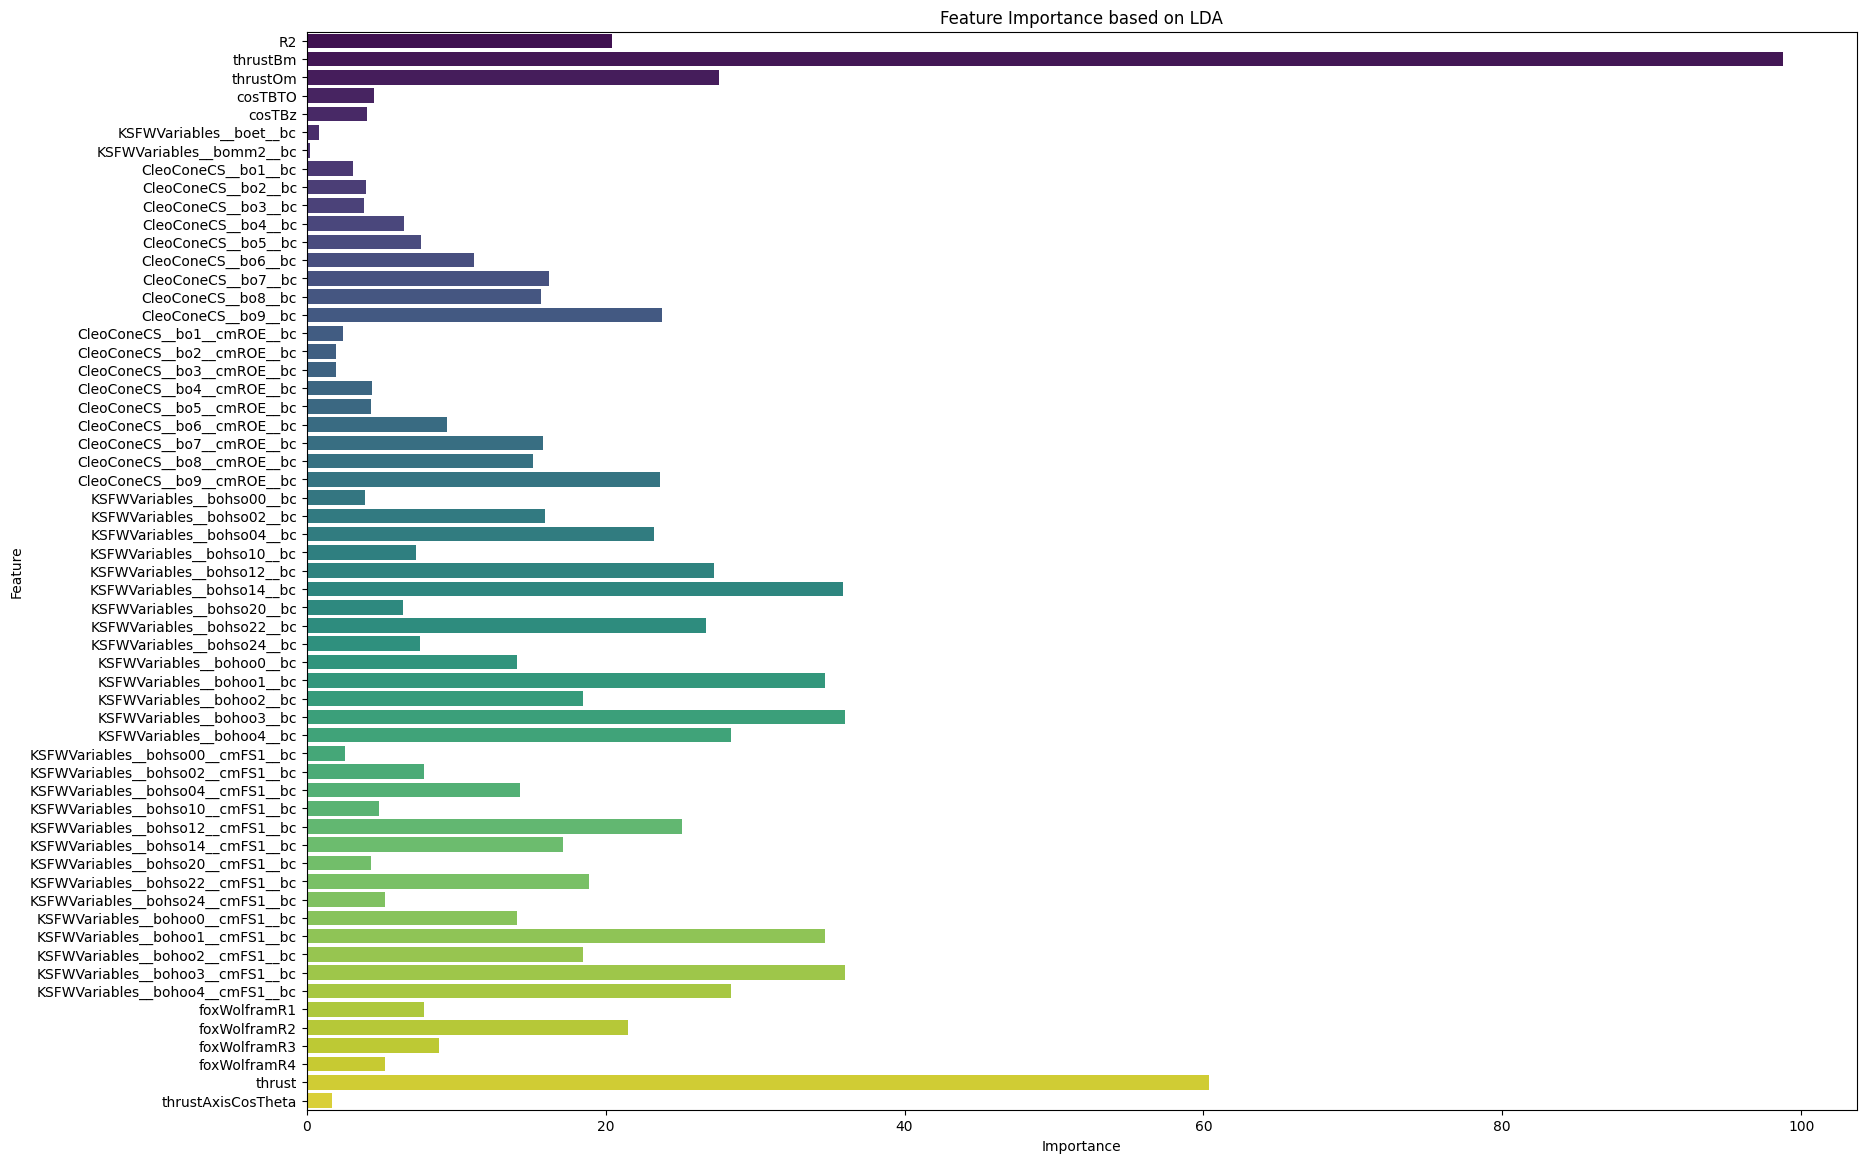

In [28]:
# WHICH FEATURE IS MORE IMPORTANT

feature_importance = np.abs(lda.coef_).sum(axis=0)
plt.figure(figsize=(20, 14))
sns.barplot(x=feature_importance, y=sampled_data.columns[:-1], palette='viridis')
plt.title('Feature Importance based on LDA')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [29]:
# MODELLING
for event_type, label in event_types.items():
    X = X_lda
    y = (sampled_data['event_type'] == label).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # MLP Classifier
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=20000, random_state=42)
    mlp.fit(X_train, y_train)
    y_pred_mlp = mlp.predict(X_test)

    accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
    report_mlp = classification_report(y_test, y_pred_mlp, zero_division=1)
    print(f"MLP Classifier - Event Type: {event_type} (Label {label}):")
    print(f'Accuracy: {accuracy_mlp:.2f}')
    print(report_mlp)

    # SVM
    svm = SVC(kernel='linear', random_state=42, class_weight='balanced')
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)

    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    report_svm = classification_report(y_test, y_pred_svm, zero_division=1)
    print(f"SVM Classifier - Event Type: {event_type} (Label {label}):")
    print(f'Accuracy: {accuracy_svm:.2f}')
    print(report_svm)

plt.show()

MLP Classifier - Event Type: e+ e- -> Upsilon(4S) -> B+ B- (Label 0):
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        97
           1       0.50      0.30      0.38        23

    accuracy                           0.81       120
   macro avg       0.67      0.62      0.63       120
weighted avg       0.78      0.81      0.79       120

SVM Classifier - Event Type: e+ e- -> Upsilon(4S) -> B+ B- (Label 0):
Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        97
           1       0.45      0.74      0.56        23

    accuracy                           0.78       120
   macro avg       0.69      0.76      0.70       120
weighted avg       0.83      0.78      0.79       120

MLP Classifier - Event Type: e+ e- -> Upsilon(4S) -> B0 B0-bar (Label 1):
Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.94      0.8

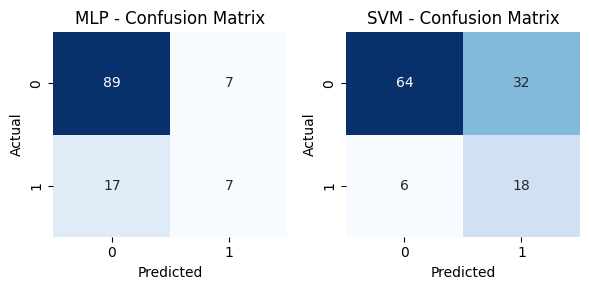

In [30]:
#CONFUSION MATRIX
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("MLP - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

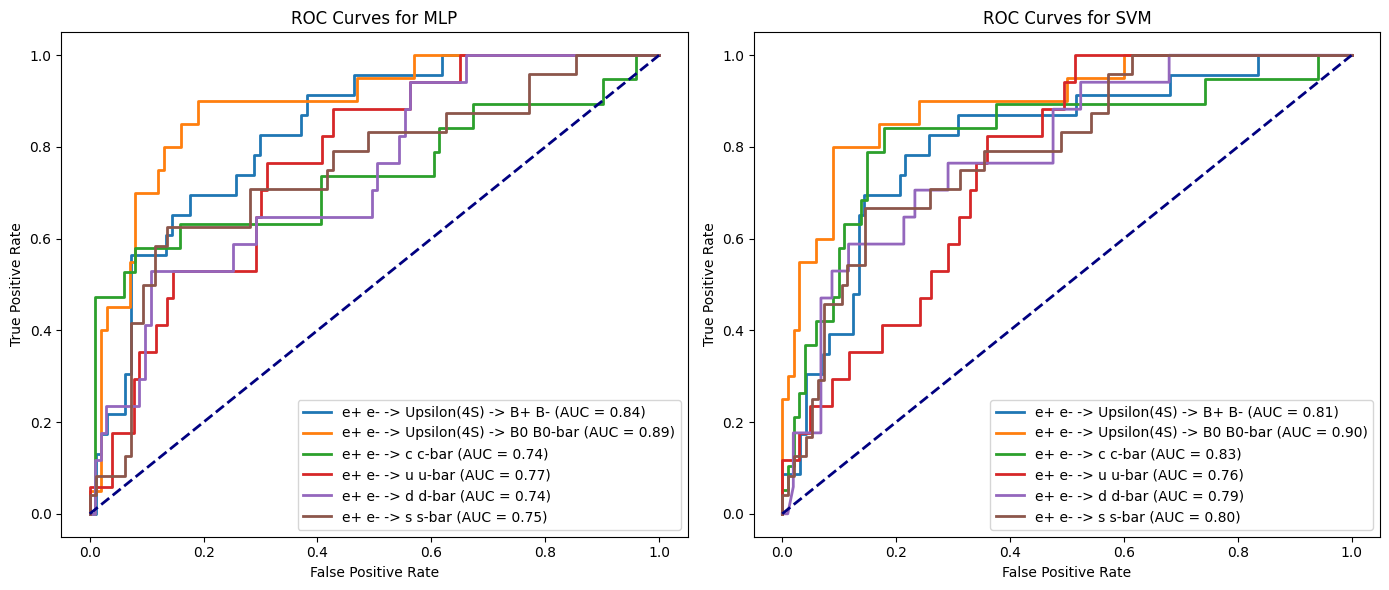

In [31]:
# ROC CURVES FOR SVM AND MLP
plt.figure(figsize=(14, 6))
for i, (model_name, model) in enumerate([('MLP', mlp), ('SVM', svm)]):
    plt.subplot(1, 2, i + 1)

    for event_type, label in event_types.items():
        y = (sampled_data['event_type'] == label).astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

        if model_name == 'SVM':
            model.probability = True
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{event_type} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(f'ROC Curves for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Evaluating MLP...


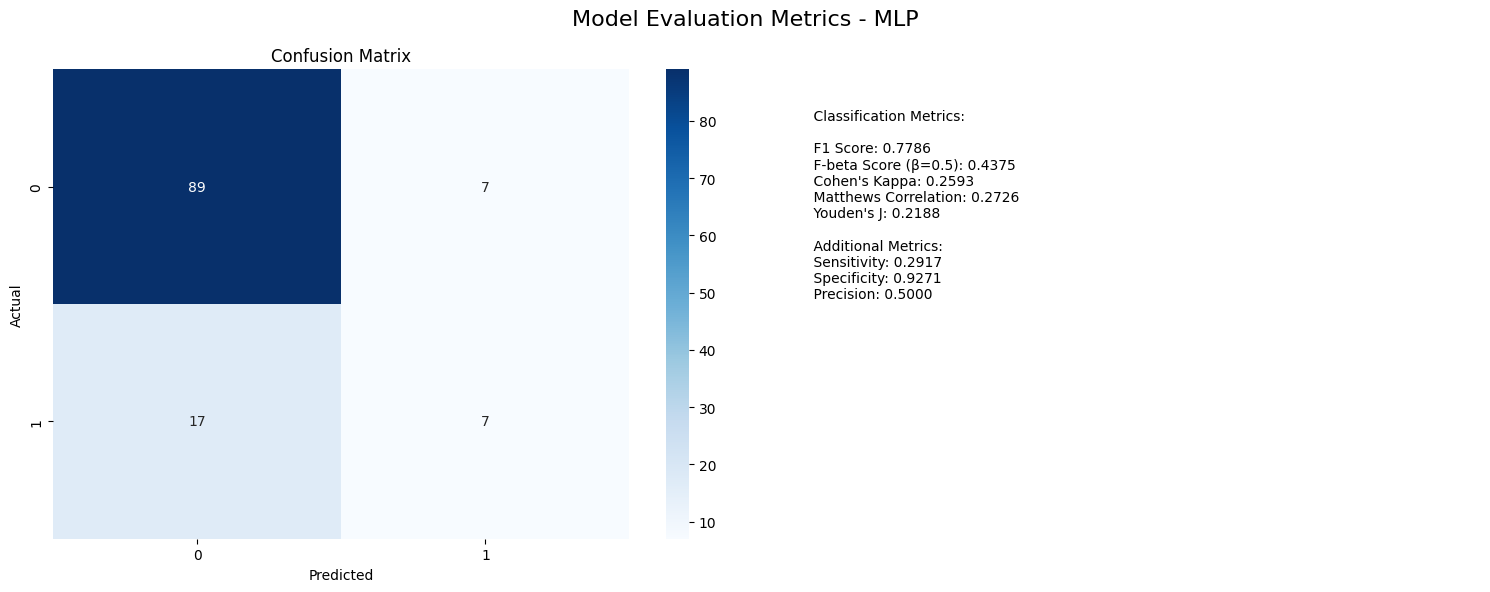


Evaluating SVM...


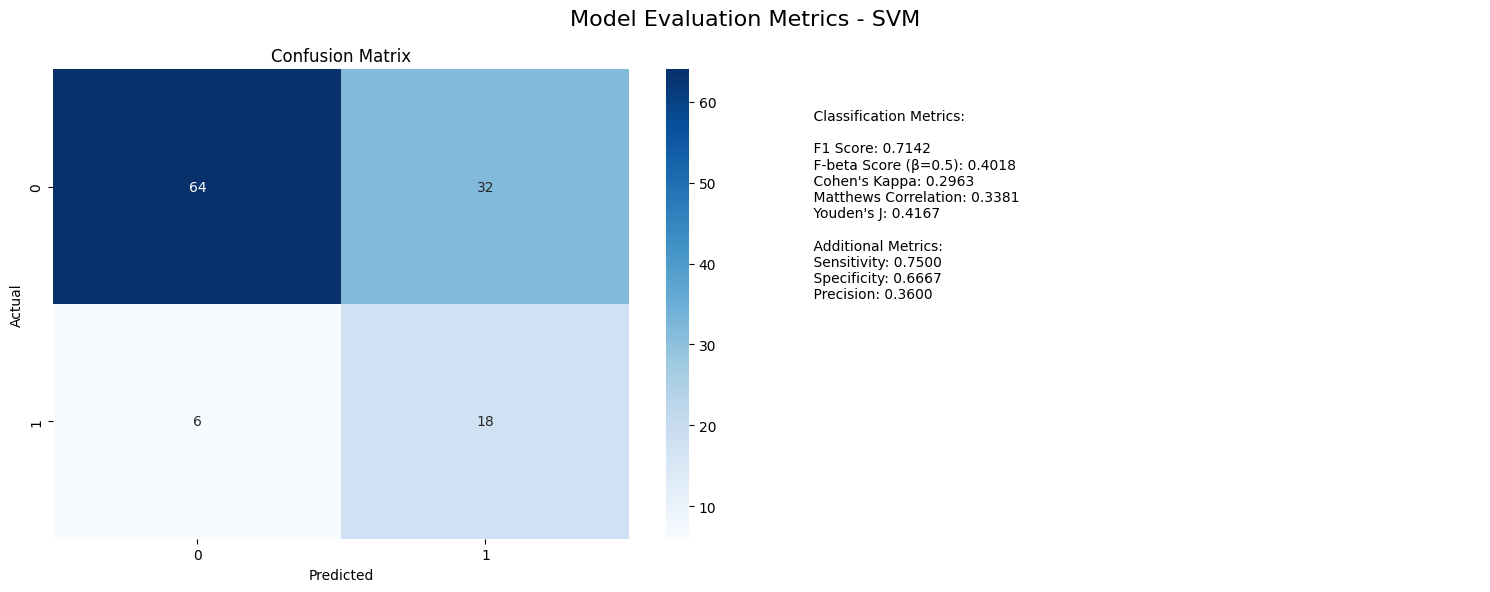


Model Comparison:
                MLP     SVM
sensitivity  0.2917  0.7500
specificity  0.9271  0.6667
youdens_j    0.2188  0.4167
f1           0.7786  0.7142
mcc          0.2726  0.3381
precision    0.5000  0.3600


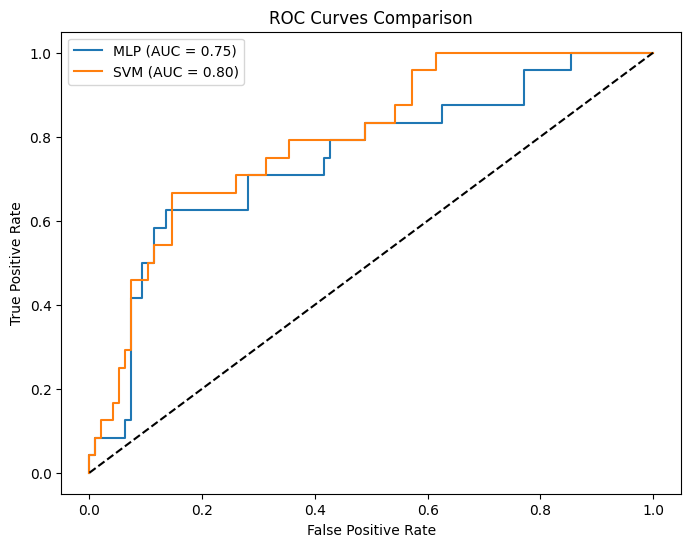

In [32]:
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    f1_score, fbeta_score, cohen_kappa_score, matthews_corrcoef,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model_name, model, X_test, y_test):
    """
    Comprehensive model evaluation function that computes various metrics
    and generates visualizations. Modified to handle models without probability predictions.
    """
    # Get predictions
    y_pred = model.predict(X_test)

    # Create figure with subplots
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Model Evaluation Metrics - {model_name}', fontsize=16)

    # 1. Confusion Matrix with annotations
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # 2. Metrics Text
    ax2.axis('off')
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    youdens_j = sensitivity + specificity - 1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    metrics_text = f"""
    Classification Metrics:

    F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}
    F-beta Score (β=0.5): {fbeta_score(y_test, y_pred, beta=0.5):.4f}
    Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}
    Matthews Correlation: {matthews_corrcoef(y_test, y_pred):.4f}
    Youden's J: {youdens_j:.4f}

    Additional Metrics:
    Sensitivity: {sensitivity:.4f}
    Specificity: {specificity:.4f}
    Precision: {precision:.4f}
    """
    ax2.text(0.05, 0.95, metrics_text, fontsize=10, va='top')

    plt.tight_layout()
    plt.show()

    return {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'youdens_j': youdens_j,
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'mcc': matthews_corrcoef(y_test, y_pred),
        'precision': precision
    }

# Retrain SVM with probability=True if you need probability predictions
svm = SVC(kernel='linear', random_state=42, class_weight='balanced', probability=True)
svm.fit(X_train, y_train)

# Evaluate models
models = {
    'MLP': mlp,
    'SVM': svm
}

results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    results[model_name] = evaluate_model(model_name, model, X_test, y_test)

# Compare models
comparison_df = pd.DataFrame(results).round(4)
print("\nModel Comparison:")
print(comparison_df)

# If you want to see ROC curves and probability-based metrics
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.show()

# Plot ROC curves for both models
plot_roc_curves(models, X_test, y_test)

In [33]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Define parameter grids for hyperparameter tuning
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 2000]
}

svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'class_weight': ['balanced', None]
}

# Loop through each event type
for event_type, label in event_types.items():
    X = X_lda
    y = (sampled_data['event_type'] == label).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Hyperparameter tuning for MLP Classifier
    mlp = MLPClassifier(random_state=42)
    mlp_grid_search = GridSearchCV(mlp, mlp_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    mlp_grid_search.fit(X_train, y_train)
    best_mlp = mlp_grid_search.best_estimator_

    # Predict and evaluate MLP
    y_pred_mlp = best_mlp.predict(X_test)
    accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
    report_mlp = classification_report(y_test, y_pred_mlp, zero_division=1)
    print(f"MLP Classifier - Event Type: {event_type} (Label {label}):")
    print(f'Best Parameters: {mlp_grid_search.best_params_}')
    print(f'Accuracy: {accuracy_mlp:.2f}')
    print(report_mlp)

    # Hyperparameter tuning for SVM
    svm = SVC(random_state=42)
    svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    svm_grid_search.fit(X_train, y_train)
    best_svm = svm_grid_search.best_estimator_

    # Predict and evaluate SVM
    y_pred_svm = best_svm.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    report_svm = classification_report(y_test, y_pred_svm, zero_division=1)
    print(f"SVM Classifier - Event Type: {event_type} (Label {label}):")
    print(f'Best Parameters: {svm_grid_search.best_params_}')
    print(f'Accuracy: {accuracy_svm:.2f}')
    print(report_svm)

MLP Classifier - Event Type: e+ e- -> Upsilon(4S) -> B+ B- (Label 0):
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'sgd'}
Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        97
           1       0.67      0.35      0.46        23

    accuracy                           0.84       120
   macro avg       0.76      0.65      0.68       120
weighted avg       0.82      0.84      0.82       120

SVM Classifier - Event Type: e+ e- -> Upsilon(4S) -> B+ B- (Label 0):
Best Parameters: {'C': 0.1, 'class_weight': None, 'kernel': 'linear'}
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        97
           1       1.00      0.00      0.00        23

    accuracy                           0.81       120
   macro avg       0.90      0.50      0.45       120
weighted avg       0.85      